In [10]:
from WD.datasets import Conditional_Dataset_Zarr
import numpy as np
import torch
import zarr
import torch
from torch.utils.data import Sampler, RandomSampler, BatchSampler, SequentialSampler
import dask

In [19]:
a = zarr.open("/data/compoundx/WeatherDiff/model_input/7E2101_test.zarr")

In [21]:
a.inputs.data.info

Name,/inputs/data
Type,zarr.core.Array
Data type,float32
Shape,"(2917, 1, 32, 64)"
Chunk shape,"(2917, 1, 32, 64)"
Order,C
Read-only,False
Compressor,None
Store type,zarr.storage.DirectoryStore
No. bytes,23896064 (22.8M)
No. bytes stored,23896438 (22.8M)


In [ ]:
def get_conditioning_indices(start_index, conditioning_timesteps, batch_size, max_index):
    max_rel_index = max_index - start_index
    return (np.arange(min(batch_size, max_rel_index))[:,None] + conditioning_timesteps).ravel() + start_index

def get_target_indices(start_index, lead_time, batch_size, max_index):
    max_rel_index = max_index - start_index
    return (np.arange(min(batch_size, max_rel_index))[:,None] + lead_time).ravel() + start_index

In [ ]:
def iterator(zarr_group, start, stop, batch_size, conditioning_timesteps, lead_time):
    # careful when calculating number of samples!
    array_inputs = zarr_group.inputs.data
    array_targets = zarr_group.targets.data
    array_constants = zarr_group.constants.data

    assert stop <= array_inputs.shape[0] - lead_time
    chunk_size = array_inputs.chunks[0]
    effective_batchsize = batch_size - min(conditioning_timesteps) + lead_time
    chunks_per_batch = np.ceil(effective_batchsize / chunk_size)

    starts = np.arange(start, stop, batch_size)
    current_chunk = -1
    
    for j in starts:
        print(j, np.arange(j, min(j+batch_size, stop)))
        if j >= (current_chunk+1) * chunk_size:
            chunks_input = torch.tensor(array_inputs.oindex[np.arange(current_chunk * chunk_size, min((chunks_per_batch + 1 + current_chunk) * chunk_size, stop), dtype=int),:,:,:])
            chunks_targets= torch.tensor(array_targets.oindex[np.arange(current_chunk * chunk_size, min((chunks_per_batch + 1 + current_chunk) * chunk_size, stop), dtype=int),:,:,:])
            current_chunk = j // chunk_size

        input_data = chunks_input[get_conditioning_indices(j, conditioning_timesteps=conditioning_timesteps, batch_size=batch_size, max_index=stop) % chunk_size]
        input_data = input_data.view(-1, len(conditioning_timesteps)*input_data.shape[1], *input_data.shape[2:])
        output_data = chunks_targets[get_target_indices(j, lead_time=lead_time, batch_size=batch_size, max_index=stop) % chunk_size]

        input_data = torch.concatenate((input_data, torch.tensor(array_constants[:])[None,...].repeat(input_data.shape[0], 1, 1, 1)), dim=1)
        yield input_data, output_data


In [ ]:
a = zarr.open("/data/compoundx/WeatherDiff/model_input/9921EA_train.zarr")

In [29]:
for k, j in iterator(a, 0, 100, 8, [0,-1,-2], lead_time=2):
    print(k.shape[0])

NameError: name 'iterator' is not defined

In [2]:
from WD.datasets import Conditional_Dataset_Zarr_Iterable, Conditional_Dataset
from torch.utils.data import DataLoader
import torch
import matplotlib.pyplot as plt
import zarr
from WD.datasets import write_conditional_datasets

# Do the dataloaders return the same values in the unshuffled case?

In [2]:
ds = Conditional_Dataset_Zarr_Iterable(zarr_file_path="/data/compoundx/WeatherDiff/model_input/079A9C_test.zarr", config_file_path="/data/compoundx/WeatherDiff/config_file/079A9C.yml", shuffle_chunks=False, shuffle_in_chunks=False)
ds2 = Conditional_Dataset(pt_file_path="/data/compoundx/WeatherDiff/model_input/278771_test.pt", config_file_path="/data/compoundx/WeatherDiff/config_file/278771.yml")

In [3]:
dl = DataLoader(ds, batch_size=500)
dl2 = DataLoader(ds2, batch_size=500, shuffle=False)

In [41]:
for (input1, target1), (input2, target2, _) in zip(dl, dl2):
    
    print((input1[:,0:10,...] == input2[:,0:10,...]).all())

tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)

In [5]:
next(iter(dl))

[tensor([[[[0.8375, 0.8378, 0.8381,  ..., 0.8368, 0.8370, 0.8372],
           [0.8301, 0.8311, 0.8322,  ..., 0.8296, 0.8293, 0.8295],
           [0.8197, 0.8212, 0.8228,  ..., 0.8174, 0.8182, 0.8190],
           ...,
           [0.3430, 0.3356, 0.3279,  ..., 0.3634, 0.3569, 0.3503],
           [0.3535, 0.3460, 0.3386,  ..., 0.3729, 0.3663, 0.3601],
           [0.3795, 0.3765, 0.3737,  ..., 0.3889, 0.3857, 0.3826]],
 
          [[0.4548, 0.4558, 0.4567,  ..., 0.4532, 0.4536, 0.4541],
           [0.4362, 0.4403, 0.4454,  ..., 0.4319, 0.4313, 0.4330],
           [0.4228, 0.4295, 0.4417,  ..., 0.4248, 0.4213, 0.4200],
           ...,
           [0.3437, 0.3332, 0.3205,  ..., 0.3654, 0.3592, 0.3520],
           [0.3449, 0.3348, 0.3242,  ..., 0.3773, 0.3672, 0.3559],
           [0.3449, 0.3396, 0.3344,  ..., 0.3605, 0.3553, 0.3501]],
 
          [[0.5007, 0.5023, 0.5041,  ..., 0.4980, 0.4986, 0.4996],
           [0.4711, 0.4791, 0.4884,  ..., 0.4652, 0.4642, 0.4662],
           [0.4607, 0.46

In [11]:
a = ( == nenext(iter(dl2))[0]xt(iter(dl))[0])

In [16]:
for i in range(a.shape[0]):
    print(a[i,0].all())

tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)
tensor(True)

In [30]:
a[:,10].all()

tensor(False)

In [38]:
(next(iter(dl2))[0][0,0:10,...] == next(iter(dl))[0][0,0:10,...]).all()

tensor(True)

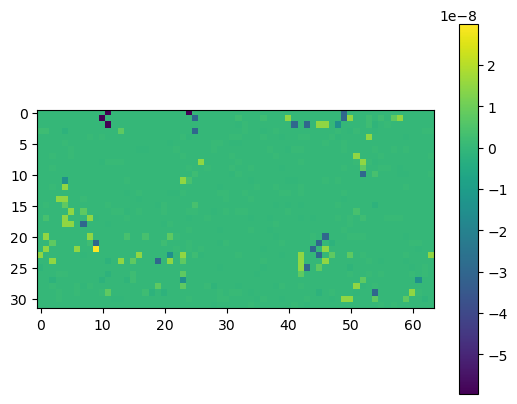

In [40]:
plt.imshow(next(iter(dl2))[0][0,10,...] - next(iter(dl))[0][0,10,...])
plt.colorbar()

In [6]:
# Test zarr read speads.

z = zarr.open("/home/wider/Projects/diffusion-models-for-weather-prediction/test_zarr/test.zarr",  mode='w', shape=(1e5, 1e4), chunks=(10000, 10000), compressor=None)

z[:] = 0

In [9]:
a = zarr.open("/home/wider/Projects/diffusion-models-for-weather-prediction/test_zarr/test.zarr",  mode='r')

In [15]:
a.oindex[0:10,:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [6]:
b = zarr.open("/data/compoundx/WeatherDiff/model_input/079A9C_train.zarr/",  mode='r')

In [7]:
z1 = zarr.open("/home/wider/Projects/diffusion-models-for-weather-prediction/test_zarr/test2.zarr",  mode='w', shape=(54049, 5, 32, 64), chunks=(54049, 5, 32, 64), compressor=None)
z2 = zarr.open("/home/wider/Projects/diffusion-models-for-weather-prediction/test_zarr/test3.zarr",  mode='w', shape=(54049, 5, 32, 64), chunks=(1, 5, 32, 64), compressor=None)

In [9]:
z1[:,:,:,:] = b.inputs.data[:,:,:,:]

In [10]:
z2[:,:,:,:] = b.inputs.data[:,:,:,:]

In [41]:
z1[:,:,:,:] = b.inputs.data[:,:,:,:]
z1[:,:,:,:] = b.inputs.data[:,:,:,:]

KeyboardInterrupt: 

In [11]:
test2 = zarr.open("/home/wider/Projects/diffusion-models-for-weather-prediction/test_zarr/test2.zarr",  mode='r')
test3 = zarr.open("/home/wider/Projects/diffusion-models-for-weather-prediction/test_zarr/test3.zarr",  mode='r')

In [19]:
# load entire chunk
a = test2[:,:,:,:]

for i in range(len(a)):
    # access elements one time step at a time
    a[i,...]

In [21]:
# open one chunk at a time
for i in range(test3.shape[0]):
    # access elements one time step at a time
    test3[i, :, :, :]

In [3]:
from WD.io import load_config
import numpy as np

In [4]:
class Conditional_Dataset_Zarr_Iterable(torch.utils.data.IterableDataset):
    def __init__(self, zarr_file_path, config_file_path, shuffle_chunks=False, shuffle_in_chunks=False):
        super(Conditional_Dataset_Zarr_Iterable).__init__()
        self.path = zarr_file_path
        self.data = zarr.open(self.path, mode="r")

        self.array_inputs = self.data.inputs.data
        self.array_targets = self.data.targets.data
        self.array_constants = self.data.constants.data    

        # we need to load the lead time and the conditioning time steps
        config = load_config(config_file_path)
        self.lead_time = config.data_specs.lead_time
        self.conditioning_timesteps = torch.tensor(
            config.data_specs.conditioning_time_step,
            dtype=int,
        )
        self.max_abs_c_t = max(abs(self.conditioning_timesteps)).numpy()

        self.chunk_size = self.array_targets.chunks[0]
        self.n_chunks = self.array_targets.nchunks

        self.start = self.max_abs_c_t
        self.stop = self.array_targets.shape[0] - self.lead_time


        self.indices = torch.ones(self.n_chunks*self.chunk_size, dtype=bool)
        self.indices[:self.start] = False
        self.indices[self.stop:] = False
        self.indices = self.indices.view(self.n_chunks, self.chunk_size)

        self.lat = self.data.targets.lat[:]
        self.lon = self.data.targets.lon[:]

        self.shuffle_chunks = shuffle_chunks
        self.shuffle_in_chunks = shuffle_in_chunks

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        
        if worker_info is None:  # single-process data loading, return the full iterator
            chunk_start = 0
            chunk_stop = self.n_chunks
        else:
            per_worker = int(np.ceil(self.n_chunks / float(worker_info.num_workers)))
            worker_id = worker_info.id
            chunk_start = 0 + worker_id * per_worker
            chunk_stop = min(chunk_start + per_worker, self.n_chunks)    
            
        if self.shuffle_chunks:
            perm = np.random.permutation(np.arange(chunk_start, chunk_stop))
        else:
            perm = np.arange(chunk_start, chunk_stop)

        n_previous_chunks_required_in_memory = np.ceil(self.max_abs_c_t / self.chunk_size).astype(int)
        n_future_chunks_required_in_memory = np.ceil(self.lead_time / self.chunk_size).astype(int)

        for i_chunk in perm:
            valid_indices = torch.where(self.indices[i_chunk].ravel() == True)[0]
            # print(torch.amin(valid_indices), torch.amax(valid_indices))
            chunks_input = torch.tensor(self.array_inputs.oindex[np.arange(max((i_chunk - n_previous_chunks_required_in_memory) * self.chunk_size, 0), min((i_chunk + n_future_chunks_required_in_memory + 1)*self.chunk_size, self.array_inputs.shape[0]), dtype=int),:,:,:], dtype=torch.float)
            chunks_targets = torch.tensor(self.array_targets.oindex[np.arange(max((i_chunk - n_previous_chunks_required_in_memory) * self.chunk_size, 0), min((i_chunk + n_future_chunks_required_in_memory + 1)*self.chunk_size, self.array_inputs.shape[0]), dtype=int),:,:,:], dtype=torch.float)

            # depending on where we are in the chunks, a varying number of previous chunks can be loaded into memory. We need to compensate for this in our indexing.
            i_offset = self.chunk_size * min(n_previous_chunks_required_in_memory, i_chunk)

            if self.shuffle_in_chunks:
                perm_in_chunk = valid_indices[torch.randperm(len(valid_indices))] + i_offset
            else:
                perm_in_chunk = valid_indices + i_offset

            for i_in_chunk in perm_in_chunk:
                input_data = chunks_input[self.get_conditioning_indices(i_in_chunk)]
                input_data = input_data.view(len(self.conditioning_timesteps)*input_data.shape[1], *input_data.shape[2:])
                output_data = chunks_targets[self.get_target_indices(i_in_chunk)]
                input_data = torch.concatenate((input_data, torch.tensor(self.array_constants[:], dtype=torch.float)), dim=0)
                yield input_data, output_data, i_chunk, i_in_chunk

    def get_conditioning_indices(self, index):
        return self.conditioning_timesteps + index

    def get_target_indices(self, index):
        return index + self.lead_time

In [5]:
dss = Conditional_Dataset_Zarr_Iterable("/data/compoundx/WeatherDiff/model_input/079A9C_test.zarr", "/data/compoundx/WeatherDiff/config_file/079A9C.yml", shuffle_chunks=True, shuffle_in_chunks=True)
ds2 = Conditional_Dataset(pt_file_path="/data/compoundx/WeatherDiff/model_input/278771_test.pt", config_file_path="/data/compoundx/WeatherDiff/config_file/278771.yml")

In [9]:
dl = DataLoader(dss, batch_size=1)
dl2 = DataLoader(ds2, batch_size=1)

In [24]:
indices = []
targets = []
inputs  = []

for ins, tars, i_batch, i_in_batch in dl:
    # print(i_batch, i_in_batch)
    indices.append(i_in_batch)  
    targets.append(tars)
    inputs.append(ins)

values, idcs = torch.sort(torch.concatenate(indices))

targets = torch.concatenate(targets)
inputs = torch.concatenate(inputs)

targets = targets[idcs]
inputs = inputs[idcs]

In [33]:
(targets == ds2[:][1]).all()

tensor(True)

In [4]:
a = []

In [6]:
a.extend([1,2,3])
a

[1, 2, 3, 1, 2, 3]

In [7]:
import numpy as np

In [10]:
np.reshape(a, (2,3))

array([[1, 2, 3],
       [1, 2, 3]])

So all targets are exactly identical, only shuffled. 